In [2]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

# Disclaimer
This code tells eda ONLY FOR ONE VIDEO example because  
to process all videos for long period of time can take a lot of time  
and process just a couple is not really better than process just one

# Path to the video file

In [3]:
video_path = "example.mp4"

## Extracting Video Metadata

In [4]:
def extract_video_metadata(video_path):
    video = cv2.VideoCapture(video_path)
    metadata = {
        "filename": os.path.basename(video_path),
        "duration": video.get(cv2.CAP_PROP_FRAME_COUNT) / video.get(cv2.CAP_PROP_FPS),
        "frame_rate": video.get(cv2.CAP_PROP_FPS),
        "frame_count": video.get(cv2.CAP_PROP_FRAME_COUNT),
        "width": video.get(cv2.CAP_PROP_FRAME_WIDTH),
        "height": video.get(cv2.CAP_PROP_FRAME_HEIGHT),
    }
    video.release()
    return metadata

# Extract and display metadata
metadata = extract_video_metadata(video_path)
print("Video Metadata:", metadata)

Video Metadata: {'filename': 'example.mp4', 'duration': 5088.028, 'frame_rate': 24.85127833416011, 'frame_count': 126444.0, 'width': 1920.0, 'height': 1080.0}


## Display Metadata as a DataFrame

In [5]:
metadata_df = pd.DataFrame([metadata])
metadata_df

,filename,duration,frame_rate,frame_count,width,height
0,example.mp4,5088.028,24.851278,126444.0,1920.0,1080.0


## Video Resolution Visualization

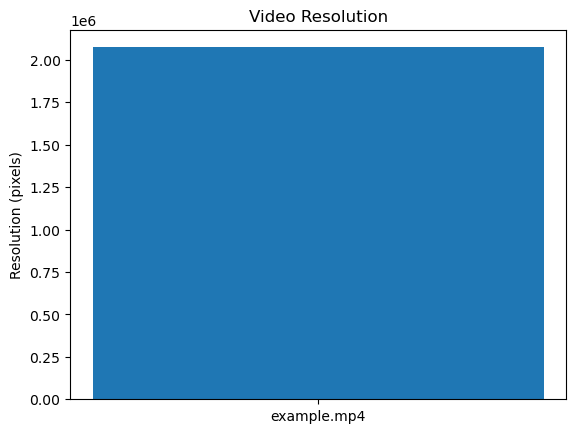

In [6]:
plt.bar([metadata["filename"]], [metadata["width"] * metadata["height"]])
plt.ylabel("Resolution (pixels)")
plt.title("Video Resolution")
plt.show()

## Extracting and Visualizing a Frame

Frame extracted and saved at frame_at_25s.jpg


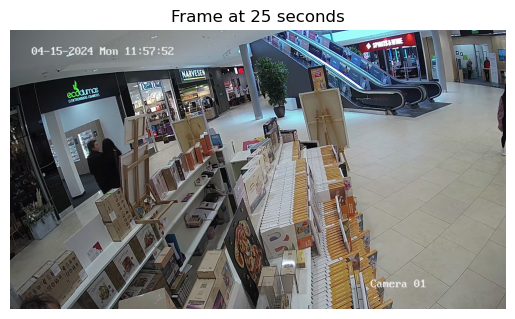

In [10]:
def extract_frame(video_path, timestamp):
    video = cv2.VideoCapture(video_path)
    video.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
    success, frame = video.read()
    if success:
        frame_path = f"frame_at_{timestamp}s.jpg"
        cv2.imwrite(frame_path, frame)
        print(f"Frame extracted and saved at {frame_path}")
    video.release()
    return frame

frame = extract_frame(video_path, 25)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Frame at 25 seconds")
plt.axis("off")
plt.show()

## Object Detection Using YOLO


0: 384x640 3 persons, 1 bus, 36.9ms
Speed: 1.6ms preprocess, 36.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


/Users/dtikhanovskii/miniconda3/envs/py3.10/lib/python3.10/site-packages/ultralytics/nn/tasks.py:567: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, m

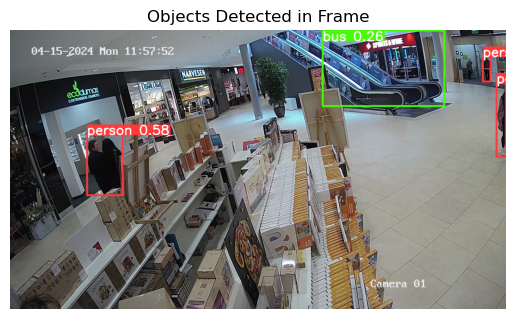

In [11]:
model = YOLO("yolov8n.pt")  # Replace with the path to your YOLO model

def detect_objects_in_frame(frame):
    results = model(frame)
    return results[0].plot()  # Plot detections on the frame

annotated_frame = detect_objects_in_frame(frame)
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.title("Objects Detected in Frame")
plt.axis("off")
plt.show()

## Detect Objects Throughout the Video

Analyzing frames: 100%|██████████| 2635/2635 [03:25<00:00, 12.80it/s]


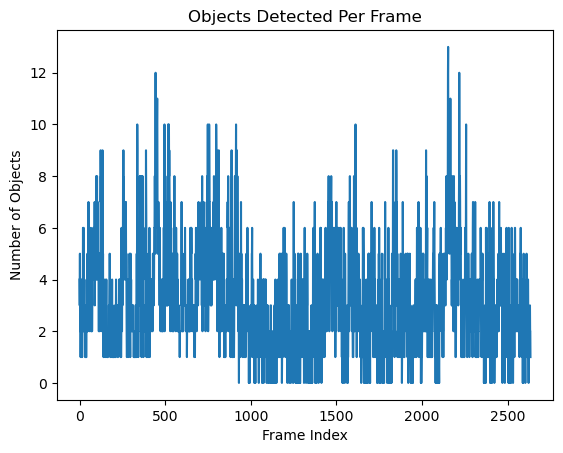

In [12]:
def detect_objects_in_video(video_path):
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_rate = int(video.get(cv2.CAP_PROP_FPS))
    detections = []
    
    # Skip more frames to make it faster (e.g., analyze every 2 seconds instead of every second)
    step = frame_rate * 2
    
    # Disable YOLO logging
    model.verbose = False
    
    # Create progress bar
    from tqdm import tqdm
    for i in tqdm(range(0, frame_count, step), desc="Analyzing frames"):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = video.read()
        if not success:
            break
        results = model(frame, verbose=False)  # Disable per-frame logging
        detections.append(len(results[0].boxes))

    video.release()
    return detections

detections = detect_objects_in_video(video_path)
plt.plot(detections)
plt.xlabel("Frame Index")
plt.ylabel("Number of Objects")
plt.title("Objects Detected Per Frame")
plt.show()

## Generate Heatmap of Object Detection

Generating heatmap: 100%|██████████| 264/264 [00:20<00:00, 12.82it/s]


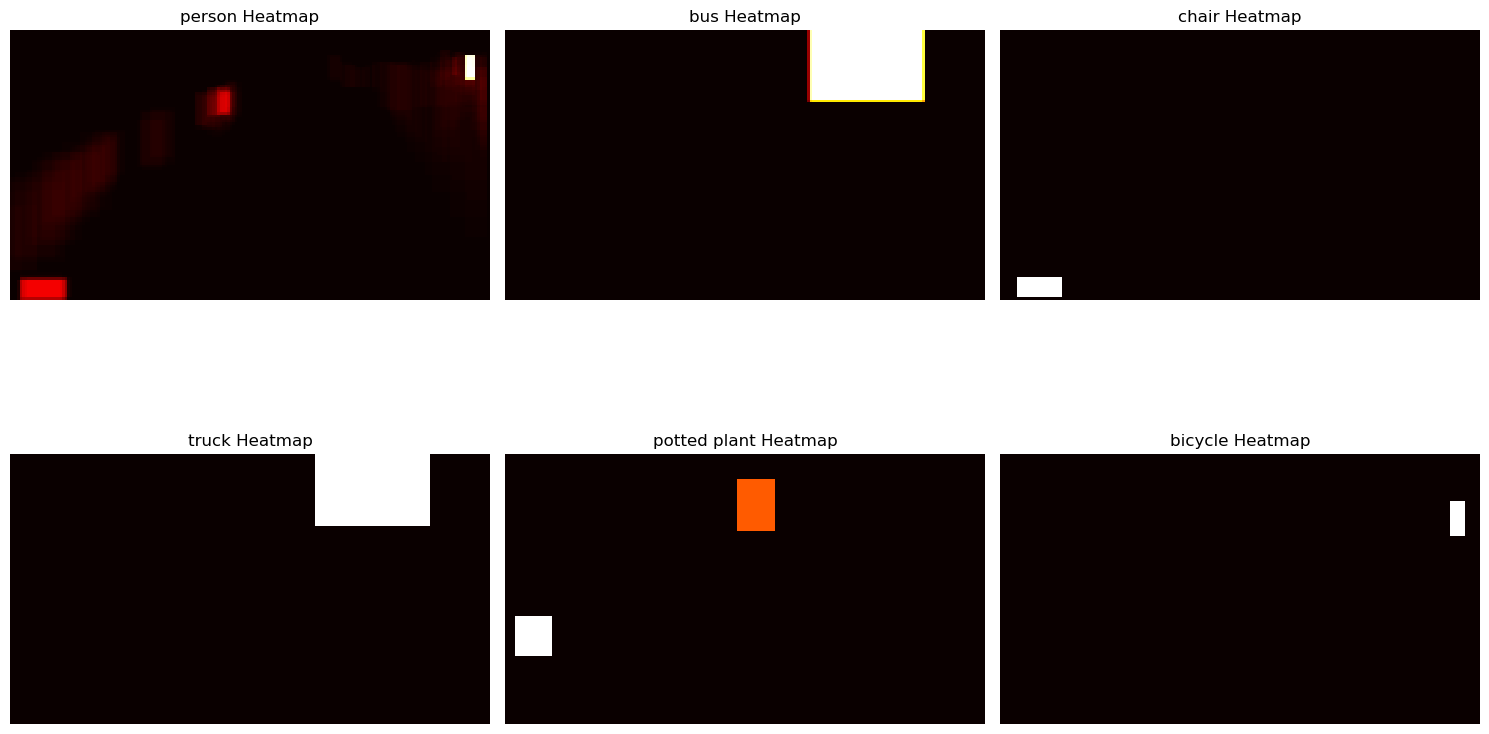


Detection counts by class:
person: 5670 regions
bus: 1363 regions
chair: 144 regions
truck: 1334 regions
potted plant: 555 regions
bicycle: 84 regions


In [13]:
# Initialize heatmap array for each class
class_heatmaps = {}

# Disable YOLO logging
model.verbose = False

# Process video frames
video = cv2.VideoCapture(video_path)
from tqdm import tqdm

for i in tqdm(range(0, len(detections), 10), desc="Generating heatmap"):
    video.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = video.read()
    if not success:
        break
        
    results = model(frame, verbose=False)
    boxes = results[0].boxes
    
    # Get class names and boxes
    for box, cls in zip(boxes.xyxy, boxes.cls):
        class_name = model.names[int(cls)]
        
        # Initialize heatmap for new class
        if class_name not in class_heatmaps:
            class_heatmaps[class_name] = np.zeros((int(metadata["height"] // 10), int(metadata["width"] // 10)))
            
        # Update heatmap for this class
        x1, y1, x2, y2 = box
        x1, x2 = int(x1 // 10), int(x2 // 10)
        y1, y2 = int(y1 // 10), int(y2 // 10)
        class_heatmaps[class_name][y1:y2, x1:x2] += 1

video.release()

# Create subplots for each class
n_classes = len(class_heatmaps)
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))

for idx, (class_name, heatmap) in enumerate(class_heatmaps.items(), 1):
    plt.subplot(n_rows, n_cols, idx)
    plt.imshow(heatmap, cmap="hot", interpolation="nearest")
    plt.title(f"{class_name} Heatmap")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print detection statistics
print("\nDetection counts by class:")
for class_name, heatmap in class_heatmaps.items():
    total_detections = np.sum(heatmap > 0)
    print(f"{class_name}: {total_detections} regions")

## Motion Analysis

Analyzing motion: 100%|██████████| 5269/5269 [04:11<00:00, 20.93it/s]


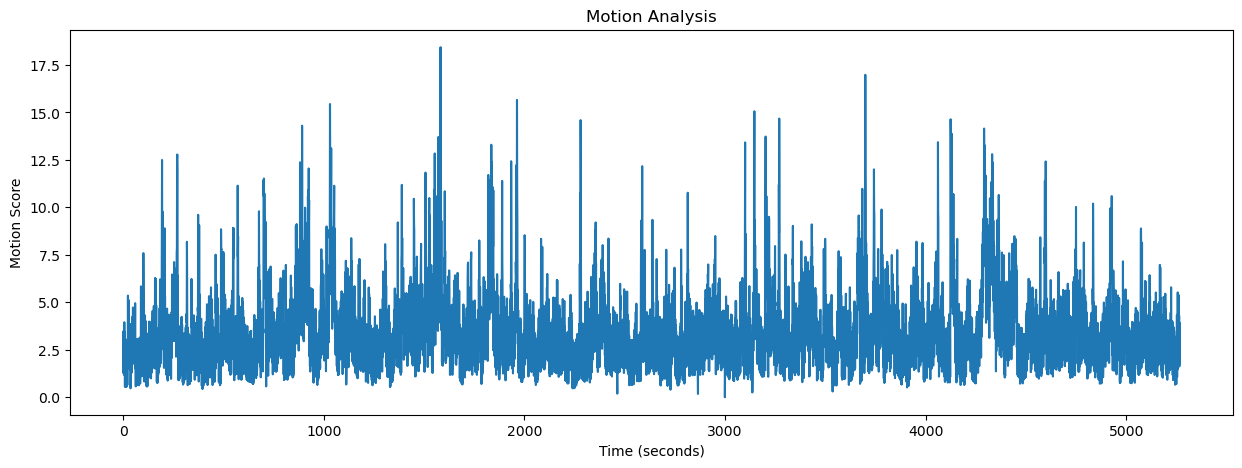

In [14]:
def analyze_motion(video_path, sample_rate=24):  # sample every second by default
    video = cv2.VideoCapture(video_path)
    motion_scores = []
    prev_frame = None
    
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for i in tqdm(range(0, frame_count, sample_rate), desc="Analyzing motion"):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = video.read()
        if not success:
            break
            
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if prev_frame is not None:
            # Calculate frame difference
            diff = cv2.absdiff(gray, prev_frame)
            motion_score = np.mean(diff)
            motion_scores.append(motion_score)
            
        prev_frame = gray
    
    video.release()
    return motion_scores

# Run motion analysis
motion_scores = analyze_motion(video_path)

# Plot motion over time
plt.figure(figsize=(15, 5))
plt.plot(motion_scores)
plt.title("Motion Analysis")
plt.xlabel("Time (seconds)")
plt.ylabel("Motion Score")
plt.show()

## Persistence Analysis

Analyzing object persistence: 100%|██████████| 5269/5269 [06:47<00:00, 12.93it/s]


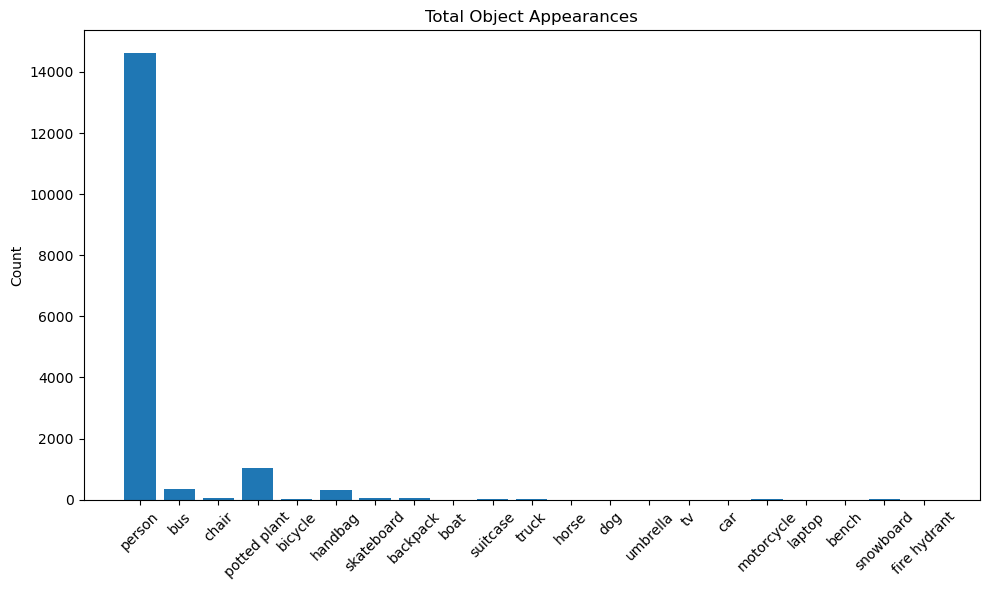

In [15]:
def analyze_object_persistence(video_path, sample_rate=24):
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    object_counts = {}  # Dictionary to store object counts over time
    
    model.verbose = False
    
    for i in tqdm(range(0, frame_count, sample_rate), desc="Analyzing object persistence"):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, frame = video.read()
        if not success:
            break
            
        results = model(frame, verbose=False)
        
        # Count objects by class
        for cls in results[0].boxes.cls:
            class_name = model.names[int(cls)]
            object_counts[class_name] = object_counts.get(class_name, 0) + 1
    
    video.release()
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(object_counts.keys(), object_counts.values())
    plt.xticks(rotation=45)
    plt.title("Total Object Appearances")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    return object_counts

# Run persistence analysis
object_counts = analyze_object_persistence(video_path)

## Object Trajectories

Tracking objects: 100%|██████████| 25289/25289 [44:59<00:00,  9.37it/s]  


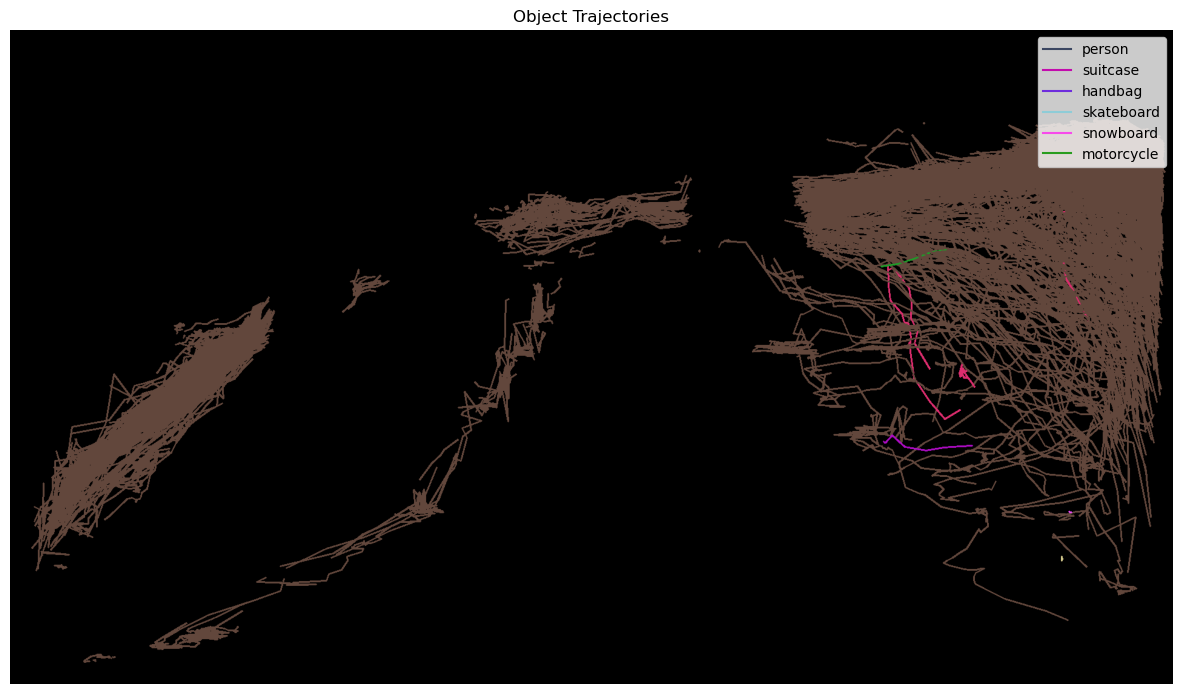


Trajectory Statistics:
person: 1676 trajectories
suitcase: 2 trajectories
handbag: 6 trajectories
skateboard: 1 trajectories
snowboard: 1 trajectories
motorcycle: 1 trajectories


In [20]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm

def track_objects(video_path, confidence_threshold=0.5, sample_rate=5, max_distance=100):
    # Dictionary to store trajectories: {track_id: [(x, y, frame_number, class_name), ...]}
    trajectories = defaultdict(list)
    active_tracks = {}  # {track_id: (last_x, last_y, class_name)}
    next_track_id = 0
    
    # Initialize video capture
    video = cv2.VideoCapture(video_path)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Disable YOLO logging
    model.verbose = False
    
    # Process frames
    for frame_number in tqdm(range(0, frame_count, sample_rate), desc="Tracking objects"):
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = video.read()
        if not success:
            break
            
        # Detect objects
        results = model(frame, verbose=False)
        
        # Current detections
        current_detections = []
        for box, conf, cls in zip(results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls):
            if conf < confidence_threshold:
                continue
            
            x1, y1, x2, y2 = map(int, box)
            center_x = (x1 + x2) // 2
            center_y = (y1 + y2) // 2
            class_name = model.names[int(cls)]
            current_detections.append((center_x, center_y, class_name))
        
        # Match detections with existing tracks
        matched_tracks = set()
        matched_detections = set()
        
        for track_id, (last_x, last_y, class_name) in active_tracks.items():
            best_distance = max_distance
            best_match = None
            
            for i, (x, y, det_class) in enumerate(current_detections):
                if i in matched_detections or det_class != class_name:
                    continue
                    
                distance = np.sqrt((x - last_x)**2 + (y - last_y)**2)
                if distance < best_distance:
                    best_distance = distance
                    best_match = i
            
            if best_match is not None:
                x, y, _ = current_detections[best_match]
                trajectories[track_id].append((x, y, frame_number, class_name))
                active_tracks[track_id] = (x, y, class_name)
                matched_tracks.add(track_id)
                matched_detections.add(best_match)
        
        # Remove unmatched tracks
        for track_id in list(active_tracks.keys()):
            if track_id not in matched_tracks:
                del active_tracks[track_id]
        
        # Create new tracks for unmatched detections
        for i, (x, y, class_name) in enumerate(current_detections):
            if i not in matched_detections:
                active_tracks[next_track_id] = (x, y, class_name)
                trajectories[next_track_id].append((x, y, frame_number, class_name))
                next_track_id += 1
    
    video.release()
    return trajectories, width, height

def visualize_trajectories(trajectories, width, height, min_points=5):
    # Create blank image
    trajectory_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Generate random colors for each class
    class_colors = {}
    
    # Draw trajectories
    for track_id, points in trajectories.items():
        if len(points) < min_points:  # Skip short trajectories
            continue
            
        # Get points and class name
        xy_points = [(x, y) for x, y, _, class_name in points]
        class_name = points[0][3]
        
        # Generate color for new class
        if class_name not in class_colors:
            class_colors[class_name] = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Draw trajectory
        points_array = np.array(xy_points, dtype=np.int32)
        cv2.polylines(trajectory_image, [points_array], False, class_colors[class_name], 2)
    
    # Create figure
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB))
    plt.title("Object Trajectories")
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], color=np.array(color)/255, label=class_name)
                      for class_name, color in class_colors.items()]
    plt.legend(handles=legend_elements)
    
    plt.axis('off')
    plt.show()
    
    # Print statistics
    print("\nTrajectory Statistics:")
    class_counts = defaultdict(int)
    for track_id, points in trajectories.items():
        if len(points) >= min_points:
            class_counts[points[0][3]] += 1
    
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} trajectories")

# Run tracking and visualization
trajectories, width, height = track_objects(video_path)
visualize_trajectories(trajectories, width, height)

## Saving Results

In [21]:
average_objects = sum(detections) / len(detections)
print(f"Average objects detected per frame: {average_objects}")

output_df = pd.DataFrame({
    "frame_index": list(range(len(detections))),
    "objects_detected": detections
})
output_df.to_csv("video_eda_results.csv", index=False)
metadata_df.to_csv("video_metadata.csv", index=False)
print("EDA results saved to video_eda_results.csv and video_metadata.csv")

Average objects detected per frame: 3.1802656546489563
EDA results saved to video_eda_results.csv and video_metadata.csv
